<a href="https://colab.research.google.com/github/StudentsAntoniPartyka/ML/blob/main/homework8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

torch.manual_seed(42)
np.random.seed(42)

In [17]:
focus1 = torch.tensor([-2.0, 0.0])
focus2 = torch.tensor([ 2.0, 0.0])
C = 6.0  # sum of distances

# number of points we will move around
N = 100

# initialize points uniformly in [-5, 5]^2
points = torch.rand((N, 2)) * 10 - 5
points.requires_grad = True

# prepare to track trajectories and loss
trajectories = [[] for _ in range(N)]
loss_history = []

In [26]:
def loss_l2(dist_sum, C):
    # squared‐error (ℓ2)
    return torch.mean((dist_sum - C)**2)

def loss_l1(dist_sum, C):
    # absolute‐error (ℓ1)
    return torch.mean(torch.abs(dist_sum - C))

def loss_linf(dist_sum, C):
    # max‐error (ℓ∞)
    return torch.max(torch.abs(dist_sum - C))

def loss_l0(dist_sum, C, k=100.0):
    # Soft approximation of ℓ0 norm using sigmoid(k * |ε|)
    eps = dist_sum - C
    return torch.mean(torch.sigmoid(k * torch.abs(eps)))

In [20]:
def plot_current(epoch, pts, loss_hist):
    plt.clf()

    # subplot 1: points
    plt.subplot(1, 2, 1)
    pts_np = pts.detach().cpu().numpy()
    plt.scatter(pts_np[:,0], pts_np[:,1], s=8, alpha=0.6)
    plt.scatter([focus1[0], focus2[0]],
                [focus1[1], focus2[1]],
                c='red', marker='x', label='foci')
    plt.axis('equal')
    plt.title(f'Epoch {epoch}')
    plt.legend()

    # subplot 2: loss curve
    plt.subplot(1, 2, 2)
    plt.plot(loss_hist, '-o', markersize=3, alpha=0.7)
    plt.title('Loss over time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [21]:
def train(points, loss_fn, lr=0.1, epochs=200, plot_every=20):
    pts = points.clone().detach().requires_grad_(True)
    opt = torch.optim.Adam([pts], lr=lr)
    loss_hist = []

    for epoch in range(1, epochs+1):
        opt.zero_grad()
        d1 = torch.norm(pts - focus1, dim=1)
        d2 = torch.norm(pts - focus2, dim=1)
        L = loss_fn(d1 + d2, C)
        L.backward()
        opt.step()

        loss_hist.append(L.item())

        if epoch % plot_every == 0 or epoch == 1:
            plot_current(epoch, pts, loss_hist)

    # final plot
    plot_current(epochs, pts, loss_hist)
    return pts, loss_hist

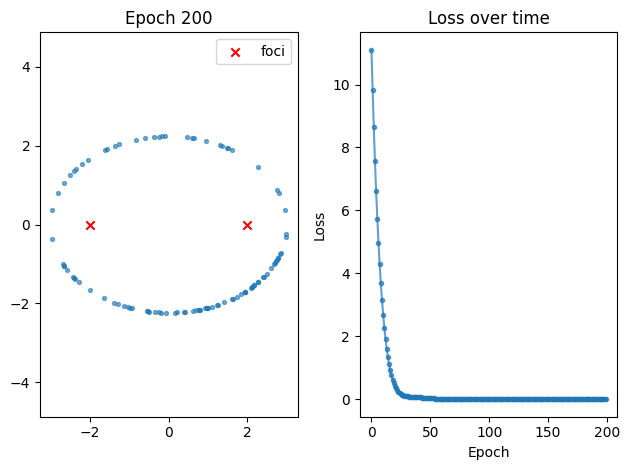

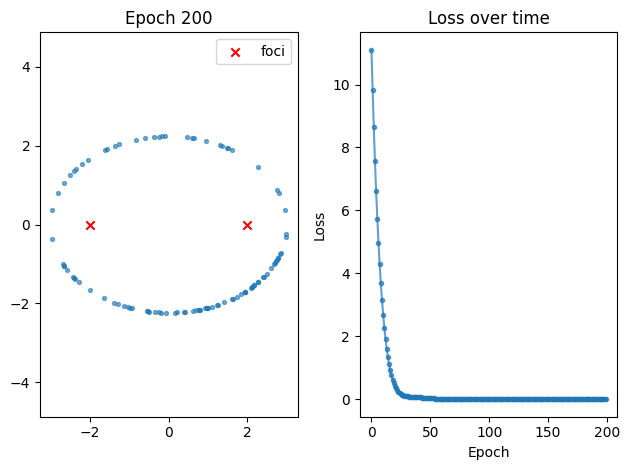

In [22]:
pts_l2, hist_l2 = train(points, loss_l2, lr=0.1, epochs=200, plot_every=50)

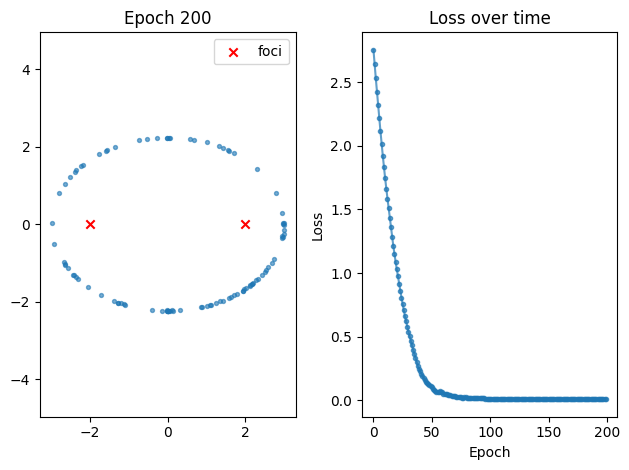

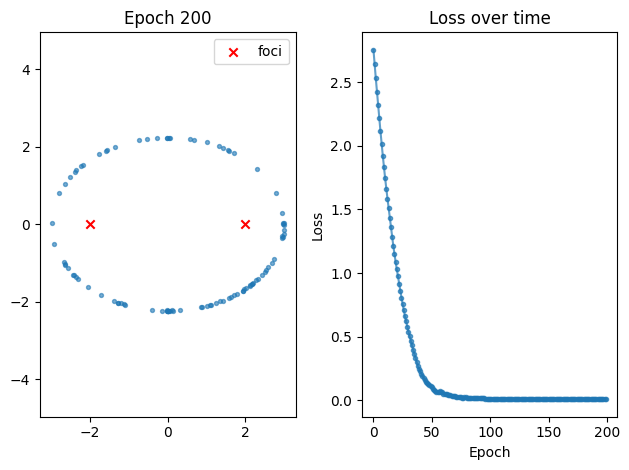

In [23]:
pts_l1, hist_l1 = train(points, loss_l1, lr=0.05, epochs=200, plot_every=50)

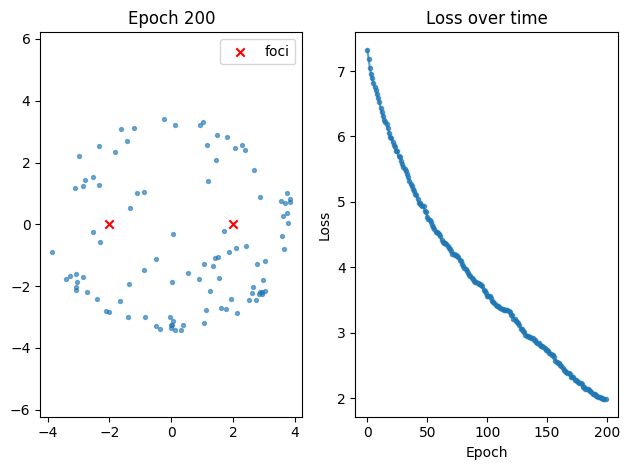

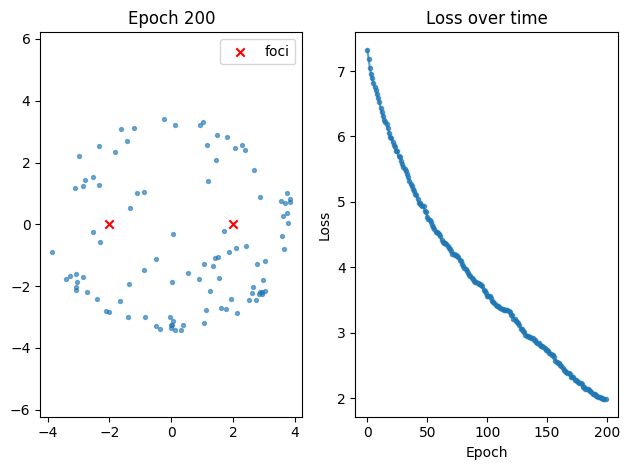

In [24]:
pts_linf, hist_linf = train(points, loss_linf, lr=0.05, epochs=200, plot_every=50)

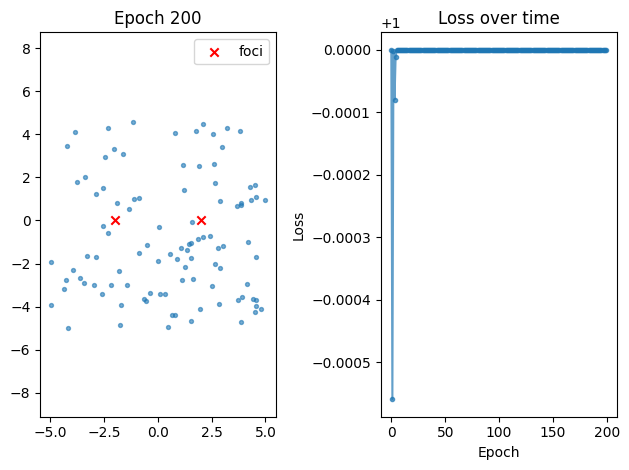

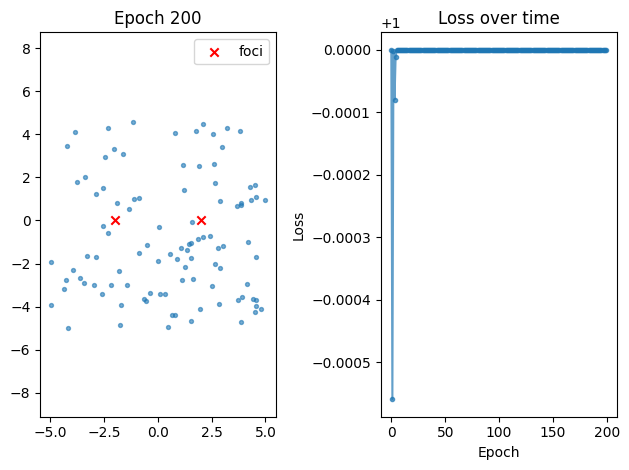

In [27]:
pts_l0, hist_l0 = train(points, loss_l0, lr=0.1, epochs=200, plot_every=50)

I had the weirdest problems with l0, no clue if this is the right implementation, but tried my best, that's why i didn't add it before, cause the function returned a tensor with no gradient as I understand and I had a lot of fun finding out hoew to fix it


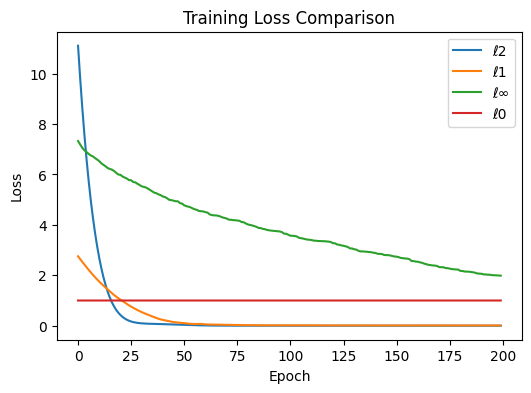

In [28]:
plt.figure(figsize=(6,4))
plt.plot(hist_l2,  label='ℓ2')
plt.plot(hist_l1,  label='ℓ1')
plt.plot(hist_linf, label='ℓ∞')
plt.plot(hist_l0,  label='ℓ0')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()


# Conclusions

1. **ℓ₂ (MSE)**: converges smoothly to zero, points form a nice ellipse.  
2. **ℓ₁ (MAE)**: converges slower, plateaus above zero because absolute‐value gradient is constant away from zero.  
3. **ℓ∞ (Max‐error)**: very slow; optimizer tries to reduce the single worst‐off point, so most points barely move, training stalls.
4. **ℓ₀ (Count-error):** no usable gradient — since the indicator 1(ε≠0) is flat almost everywhere, the optimizer can’t “see” how to move points, so training stalls completely.